In [1]:
import pandas as pd
import numpy as np
import tushare as ts
import time
import datetime as dt
from func_timeout import func_set_timeout
import func_timeout
import matplotlib
import matplotlib.pyplot as plt
import pickle
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 

In [2]:
# import the relevant Keras modules
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.metrics import mean_absolute_error

获取郑商所某年全体期货交易数据（以2021年为例）

In [4]:
pro = ts.pro_api()  # Input your token if have not been set yet. 
calendar = pro.trade_cal(exchange="CZCE", start_date="20210101", end_date="20211231")
calendar = list(calendar[calendar["is_open"] == 1]["cal_date"])

In [5]:
df = pro.fut_holding(trade_date=calendar[0], exchange="CZCE")
df.to_csv("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\czce2021.csv")
count = 1  # 日线数据获取进度

In [6]:
@func_set_timeout(30) # 设定抓取日线数据最大时间
def fetch_daily(date: str) -> pd.DataFrame:
    """
    date: string, should be the format as "yyyymmdd".
    """
    try:
        return pro.fut_holding(trade_date=date, exchange="CZCE")
    except func_timeout.exceptions.FunctionTimedOut:
        print(f"抓取数据超时，日期：{date}")

In [7]:
def fetch_data():
    global count, df
    for date in calendar[1:]:
        if count % 10 == 0:
            df.to_csv("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\czce2021.csv")
            time.sleep(30)
        count += 1
        try:
            temp = fetch_daily(date)
        except:
            df.to_csv("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\czce2021.csv")
            break
        df = pd.concat([df, temp])
    else:
        return "All data collected"
    

In [8]:
if __name__ == "__main__":
    try:
        fetch_data()
    except:
        df = pd.read_csv("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\czce2021.csv")
        del df["Unnamed: 0"]
        fetch_data()

In [9]:
count == len(calendar)

True

按照MA成交量对券商进行排序

In [10]:
df = pd.read_csv("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\czce2021.csv")
del df[df.columns[0]]
df[df["symbol"] == "MA"].groupby("broker").agg({"vol": np.nansum}).sort_values(
    ascending=False, by="vol")["vol"]

broker
东证期货    60811754
光大期货    24993085
中信期货    22443498
东吴期货    19313818
海通期货    12723205
          ...   
中投天琪           0
美尔雅            0
建信期货           0
东航期货           0
天风期货           0
Name: vol, Length: 61, dtype: int64

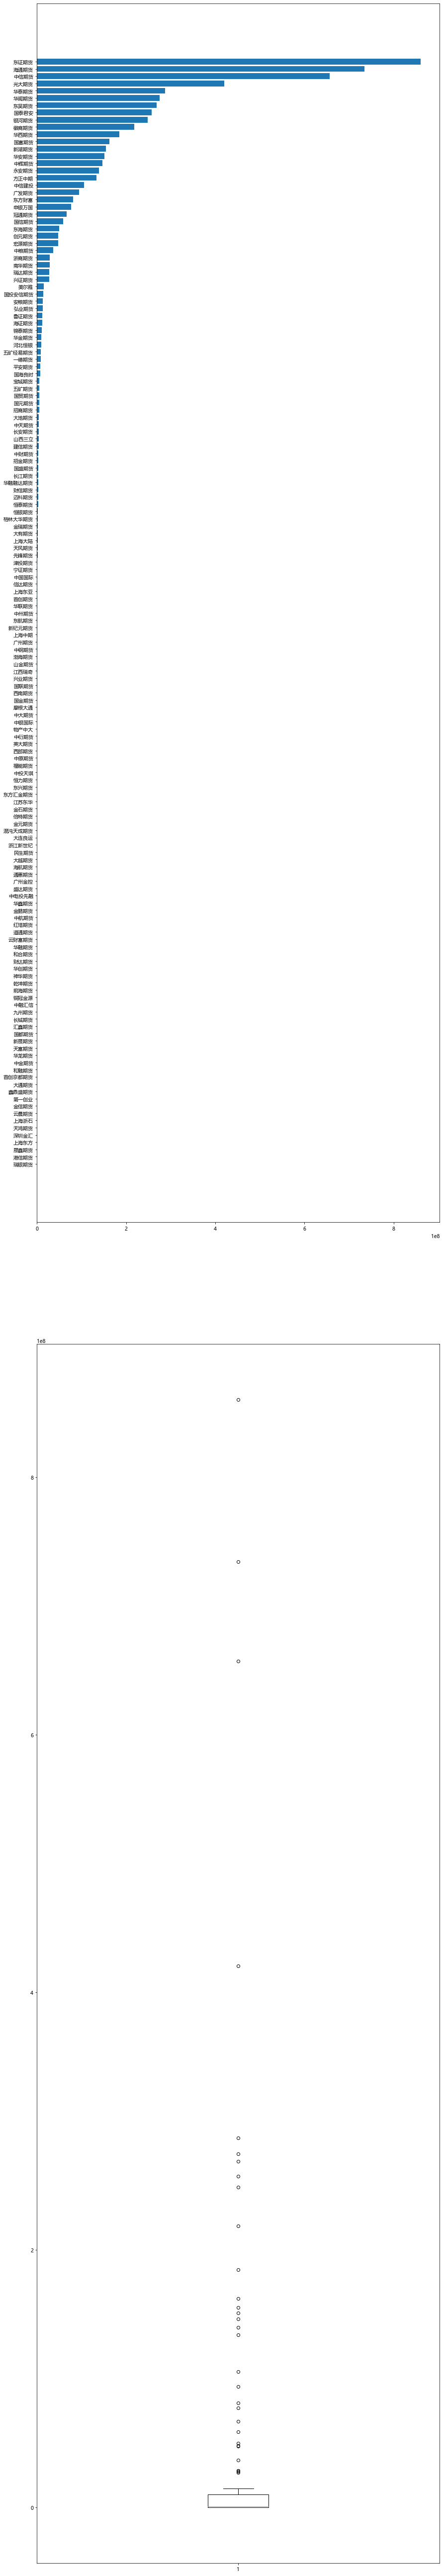

In [12]:
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(top = 18, right=2, hspace = 0.1)
axs[0].barh(y=vol_ranked.index, width=vol_ranked.values)

axs[1].boxplot(vol_ranked.values)
plt.show()

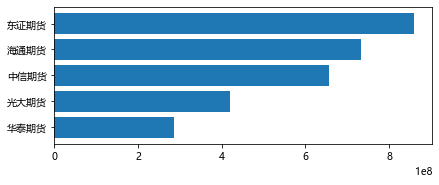

In [13]:
vol_ranked = vol_ranked[-5:].sort_values(ascending=True)
fig, axs = plt.subplots(1)
plt.subplots_adjust(top = 0.6, right= 1, hspace = 0.1)
axs.barh(y=vol_ranked.index ,width=vol_ranked[vol_ranked >= vol_ranked].values)
plt.show()

持买 / 卖变化量的预测力（MA）

In [14]:
file = open("C:\\Users\\tianj\\Desktop\\MXCaptial\\solution\\data\\total_data.pkl", "rb")
price = pickle.load(file)["MA"]
price.index = pd.to_datetime(price.index)
price = price[(pd.to_datetime("2021-01-01") <= price.index) & 
              (price.index <= pd.to_datetime("2021-12-31"))]["CLOSE"]

In [15]:
df["net"] = df["long_chg"] - df["short_chg"]
df = df[["trade_date", "symbol", "broker", "net"]]

In [16]:
df = df.set_index("broker").loc[vol_ranked.index]
df = df[df["symbol"] == "MA"].reset_index().set_index("trade_date")
del df["symbol"]
df = df.reset_index().set_index(["broker", "trade_date"]).unstack().T
df = df.reset_index().drop(columns=["level_0"]).set_index("trade_date").fillna(0)
df.index = map(lambda x: pd.to_datetime(str(x)), df.index)
price = price[df.index]
df = df/10
df["Close"] = price.values

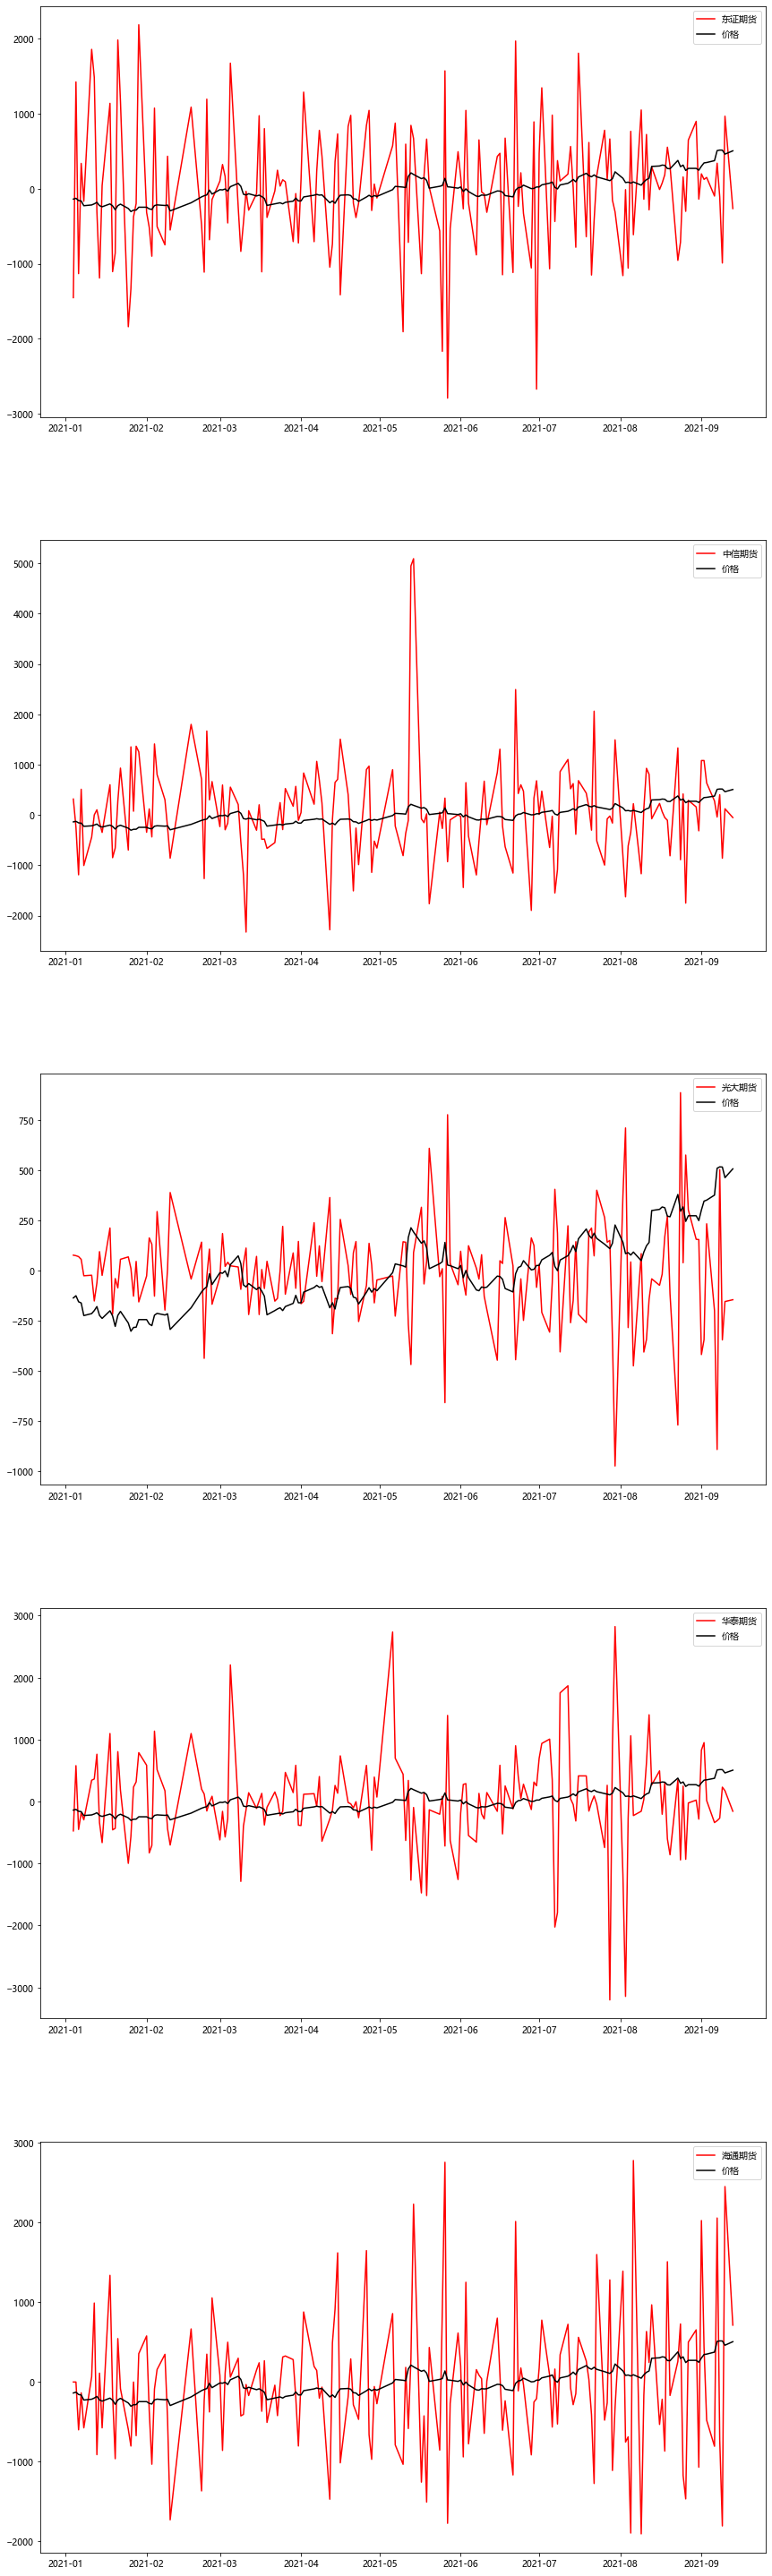

In [17]:
fig, axs = plt.subplots(5, 1)
plt.subplots_adjust(top = 10, right=2, hspace = 0.3)

axs[0].plot(df[df.columns[0]], color="red", label="东证期货")
axs[0].plot(price-np.mean(price), color="black", label="价格")
axs[0].legend()

axs[1].plot(df[df.columns[1]], color="red", label="中信期货")
axs[1].plot(price-np.mean(price), color="black", label="价格")
axs[1].legend()

axs[2].plot(df[df.columns[2]], color="red", label="光大期货")
axs[2].plot(price-np.mean(price), color="black", label="价格")
axs[2].legend()

axs[3].plot(df[df.columns[3]], color="red", label="华泰期货")
axs[3].plot(price-np.mean(price), color="black", label="价格")
axs[3].legend()

axs[4].plot(df[df.columns[4]], color="red", label="海通期货")
axs[4].plot(price-np.mean(price), color="black", label="价格")
axs[4].legend()

plt.show()